# LIBRARY

In [5]:
!pip install keras_tuner

In [6]:
import numpy as np
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare data

In [7]:
def plot_results(historical_data,predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    historical_data = scaler.inverse_transform(historical_data.reshape(-1, 1))
    predicted_data = scaler.inverse_transform(predicted_data.reshape(-1, 1))
    true_data = scaler.inverse_transform(true_data.reshape(-1, 1))
    # Define the length of the historical data
    len_historical = len(historical_data)

    # Create arrays for plotting that offset the true and predicted data
    offset_true_data = np.empty(len_historical + len(true_data))
    offset_true_data[:] = np.nan
    offset_true_data[len_historical:] = true_data.squeeze()

    offset_predicted_data = np.empty(len_historical + len(predicted_data))
    offset_predicted_data[:] = np.nan
    offset_predicted_data[len_historical:] = predicted_data.squeeze()

    # Plot the data
    ax.plot(historical_data, label='Historical Data')
    ax.plot(offset_true_data, label='True Data')
    ax.plot(offset_predicted_data, label='Predicted Data')

    plt.legend()
    plt.show()

In [8]:
# LOAD DATASETS
train_df = pd.read_csv('/content/drive/MyDrive/Time Series/Project Final/Data/HPG Historical Data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Time Series/Project Final/Data/HPG Historical Data Test.csv')

In [9]:
# Convert 'Date' column to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Sort the dataframes by 'Date' and reset the index
train_df = train_df.sort_values('Date').reset_index(drop=True)
test_df = test_df.sort_values('Date').reset_index(drop=True)

# Set the 'Date' column as the index
train_df = train_df.set_index('Date')
test_df = test_df.set_index('Date')

# Resample the dataframes to daily frequency and forward-fill missing values
train_df = train_df.asfreq('D').fillna(method="ffill")
test_df = test_df.asfreq('D').fillna(method="ffill")


In [10]:
# Convert specified columns to float
columns_to_convert = ['Price', 'Open', 'High', 'Low']
for column in columns_to_convert:
    train_df[column] = train_df[column].str.replace(',', '').astype(float)
    test_df[column] = test_df[column].str.replace(',', '').astype(float)
# Select the feature to predict, e.g., 'Price'
feature = 'Price'

In [11]:
# Normalize the data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_df[[feature]])
test_data = scaler.transform(test_df[[feature]])

In [12]:
# Prepare the data for LSTM/GRU
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)



In [13]:
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# FINE_TUNING

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

In [15]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=5, max_value=300, step=5), return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.05, max_value=0.5, step=0.05)))
    model.add(LSTM(units=hp.Int('units', min_value=5, max_value=300, step=5), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.05)))
    model.add(Dense(units=1,activation = "linear"))

    model.compile(optimizer=optimizers.AdamW(learning_rate=hp.Choice('learning_rate', values=[0.005, 0.001, 0.002])),
                  loss='mean_squared_error')

    return model

tuner = kt.RandomSearch(build_model,
                        objective='val_loss',
                        max_trials=15,
                        executions_per_trial=1,
                        directory='tuning_dir',
                        project_name='stock_price_prediction')

tuner.search(X_train, y_train, batch_size=16, epochs=30, validation_split= 0.25,callbacks=[early_stopping, reduce_lr], verbose=1)




Trial 15 Complete [00h 00m 47s]
val_loss: 0.0004133434558752924

Best val_loss So Far: 0.0003717360959853977
Total elapsed time: 00h 22m 22s


In [16]:
best_hps = tuner.get_best_hyperparameters()[0].values # Get the best hyperparameter configuration

# Print the optimal values
print("Optimal hyperparameters:")
for key, value in best_hps.items():
    print(f"{key}: {value}")

Optimal hyperparameters:
units: 280
dropout_rate: 0.2
learning_rate: 0.001


In [17]:
best_model = tuner.get_best_models(num_models=1)[0]

13/13 [==============================] - 1s 27ms/step


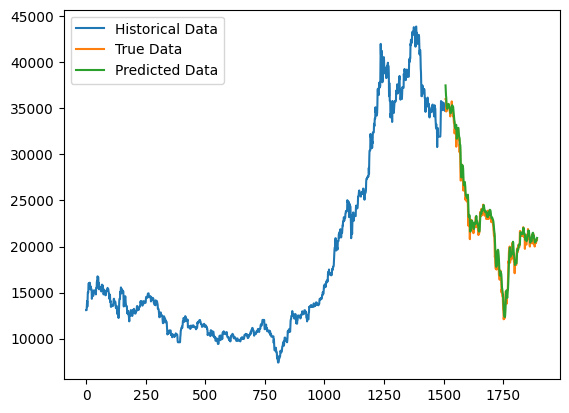

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 280)           315840    
                                                                 
 dropout (Dropout)           (None, 10, 280)           0         
                                                                 
 lstm_1 (LSTM)               (None, 280)               628320    
                                                                 
 dropout_1 (Dropout)         (None, 280)               0         
                                                                 
 dense (Dense)               (None, 1)                 281       
                                                                 
Total params: 944441 (3.60 MB)
Trainable params: 944441 (3.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
predicted_stock_price = best_model.predict(X_test)

plot_results(y_train,predicted_stock_price,y_test)
best_model.summary()

In [19]:
def build_model_GRU(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('units', min_value=5, max_value=300, step=5), return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.05, max_value=0.5, step=0.05)))
    model.add(GRU(units=hp.Int('units', min_value=5, max_value=300, step=5), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.05)))
    model.add(Dense(units=1,activation = "linear"))

    model.compile(optimizer=optimizers.AdamW(learning_rate=hp.Choice('learning_rate', values=[0.005, 0.001, 0.002])),
                  loss='mean_squared_error')

    return model

tuner1 = kt.RandomSearch(build_model_GRU,
                        objective='val_loss',
                        max_trials=15,
                        executions_per_trial=1,
                        directory='tuning_dir_GRU',
                        project_name='stock_price_prediction')

tuner1.search(X_train, y_train, batch_size=16, epochs=30, validation_split=0.25,callbacks=[early_stopping, reduce_lr], verbose=1)



Trial 15 Complete [00h 00m 47s]
val_loss: 0.000850532844197005

Best val_loss So Far: 0.00028427765937522054
Total elapsed time: 00h 16m 49s


In [20]:
best_model1 = tuner1.get_best_models(num_models=1)[0]

In [21]:
best_hps_GRU = tuner1.get_best_hyperparameters()[0].values # Get the best hyperparameter configuration

# Print the optimal values
print("Optimal hyperparameters:")
for key, value in best_hps.items():
    print(f"{key}: {value}")

Optimal hyperparameters:
units: 280
dropout_rate: 0.2
learning_rate: 0.001


13/13 [==============================] - 1s 6ms/step


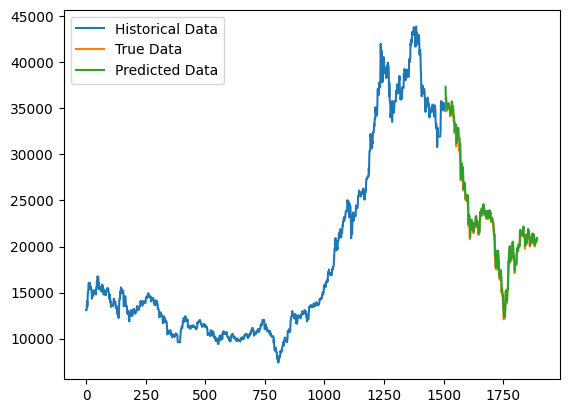

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 75)            17550     
                                                                 
 dropout (Dropout)           (None, 10, 75)            0         
                                                                 
 gru_1 (GRU)                 (None, 75)                34200     
                                                                 
 dropout_1 (Dropout)         (None, 75)                0         
                                                                 
 dense (Dense)               (None, 1)                 76        
                                                                 
Total params: 51826 (202.45 KB)
Trainable params: 51826 (202.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
gru_predictions = best_model1.predict(X_test)
plot_results(y_train,gru_predictions,y_test)
best_model1.summary()

# Evaluation

In [23]:
predicted_stock_price_rescale= scaler.inverse_transform(predicted_stock_price.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
gru_predictions_rescale= scaler.inverse_transform(gru_predictions.reshape(-1, 1))

In [25]:
def evaluate_model(predictions, actual):
    r2 = r2_score(actual, predictions)
    mape = mean_absolute_percentage_error(actual, predictions)

    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mse= mean_squared_error(actual, predictions)
    return r2, mape, rmse,mse

# Evaluate LSTM
lstm_r2, lstm_mape, lstm_rmse,mse = evaluate_model(predicted_stock_price_rescale, y_test)
print(f"LSTM - R2: {lstm_r2}, MAPE: {lstm_mape}, RMSE: {lstm_rmse}, MSE:{mse}")

# Evaluate GRU
gru_r2, gru_mape, gru_rmse,mse = evaluate_model(gru_predictions_rescale, y_test)
print(f"GRU - R2: {gru_r2}, MAPE: {gru_mape}, RMSE: {gru_rmse}, MSE:{mse}")

LSTM - R2: 0.9855937653031543, MAPE: 0.022871303744308666, RMSE: 673.1734391358909, MSE:453162.4791580431
GRU - R2: 0.9904287115828765, MAPE: 0.017761997624949982, RMSE: 548.7024897232174, MSE:301074.4222284574
